In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import mplfinance as mpf

In [2]:
# Load stock data
company = "AAPL"
start = dt.date(2012, 1, 1)
end = dt.date.today()

data = web.DataReader(company, "yahoo", start, end)
data


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.575918
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.643503
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.783868
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.917510
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.897021
...,...,...,...,...,...,...
2022-03-23,172.639999,167.649994,167.990005,170.210007,98062700.0,170.210007
2022-03-24,174.139999,170.210007,171.059998,174.070007,90131400.0,174.070007
2022-03-25,175.279999,172.750000,173.880005,174.720001,80470700.0,174.720001


In [3]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data["Close"].values.reshape(-1, 1))

prediction_days = 60
future_day = 30

X_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_day):
    X_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x+future_day, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [4]:
# Build the Model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) # prevent overfitting
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # prediction of the next closing value

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=25, batch_size=32)

# model.save()

2022-03-29 12:35:13.494845: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/25
78/78 [==============================] - 4s 34ms/step - loss: 0.0123
Epoch 2/25
78/78 [==============================] - 3s 36ms/step - loss: 0.0029
Epoch 3/25
78/78 [==============================] - 3s 36ms/step - loss: 0.0029
Epoch 4/25
78/78 [==============================] - 3s 36ms/step - loss: 0.0028
Epoch 5/25
78/78 [==============================] - 3s 36ms/step - loss: 0.0030
Epoch 6/25
78/78 [==============================] - 3s 37ms/step - loss: 0.0030
Epoch 7/25
78/78 [==============================] - 3s 36ms/step - loss: 0.0025
Epoch 8/25
78/78 [==============================] - 3s 36ms/step - loss: 0.0026
Epoch 9/25
78/78 [==============================] - 3s 37ms/step - loss: 0.0025
Epoch 10/25
78/78 [==============================] - 3s 36ms/step - loss: 0.0024
Epoch 11/25
78/78 [==============================] - 3s 37ms/step - loss: 0.0024
Epoch 12/25
78/78 [==============================] - 3s 39ms/step - loss: 0.0025
Epoch 13/25
78/78 [==================

In [5]:
# Test the model accuracy on existing data
# Load Test Data
test_start = dt.date(2020, 1, 1) + dt.timedelta(days=-prediction_days)
test_end = dt.date.today()

test_data = web.DataReader(company, "yahoo", test_start, test_end)
actual_prices = test_data["Close"].values

total_dataset = pd.concat((data["Close"], test_data["Close"]), axis=0)

model_inputs = total_dataset[
    len(total_dataset) - len(test_data) - prediction_days :
].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)


In [6]:
# Make Predictions on Test Data
X_test = []

for x in range(prediction_days, len(model_inputs)):
    X_test.append(model_inputs[x - prediction_days:x, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


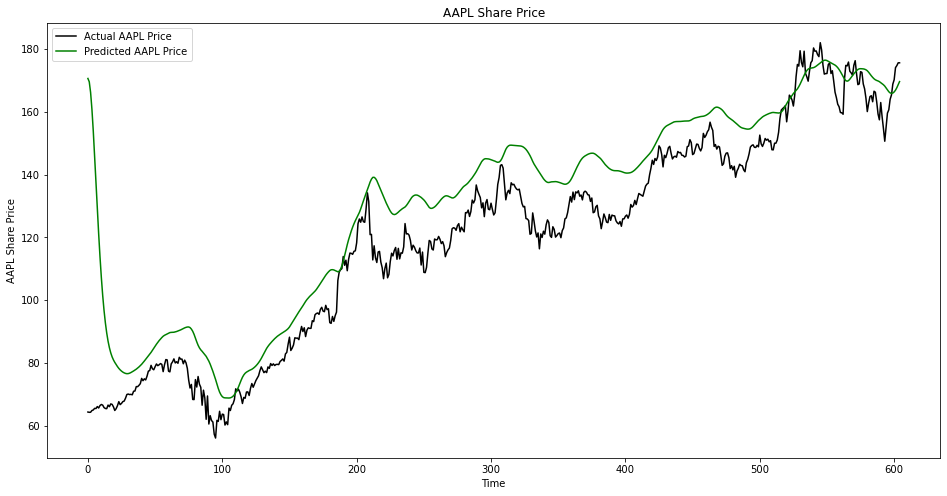

In [10]:
# Plot the test predictions
plt.figure(figsize=(16,8))
plt.plot(actual_prices, color = "black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend(loc='upper left')
plt.savefig(f"./plot/{company}_LSTM_predicted.png")

In [8]:
# Predict Next Day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]
real_data
# real_data = np.array(real_data)
# real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
# print(scaler.inverse_transform(real_data[-1]))

# prediction = model.predict(real_data)
# prediction = scaler.inverse_transform(prediction)
# print(f"Prediction: {prediction}")

[array([0.98625513, 0.95781333, 0.94043886, 0.94145037, 0.9415694 ,
        0.95876538, 0.96144294, 0.9415694 , 0.94680558, 0.92734851,
        0.90610636, 0.89587207, 0.88337677, 0.87867609, 0.8677278 ,
        0.86719231, 0.86439572, 0.93050209, 0.95698031, 0.9559688 ,
        0.96328748, 0.94579397, 0.94275942, 0.93841582, 0.95727784,
        0.96590557, 0.94115285, 0.92044629, 0.92187436, 0.94513945,
        0.94371147, 0.92187436, 0.91247309, 0.89474161, 0.8694534 ,
        0.88534034, 0.89789519, 0.89950167, 0.88807736, 0.90806993,
        0.90610636, 0.88789887, 0.86487175, 0.85380443, 0.88658982,
        0.86023062, 0.83767944, 0.81322424, 0.8398215 , 0.86659725,
        0.87272592, 0.89271849, 0.90104878, 0.92151737, 0.9297881 ,
        0.95275575, 0.95662332, 0.9618595 , 0.9618595 ])]